In [61]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [62]:
# загрузка данных
wage = pd.read_table('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
wage.columns = ['monthly_wage']

In [63]:
wage.head()

,monthly_wage
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


### Визуальный анализ ряда

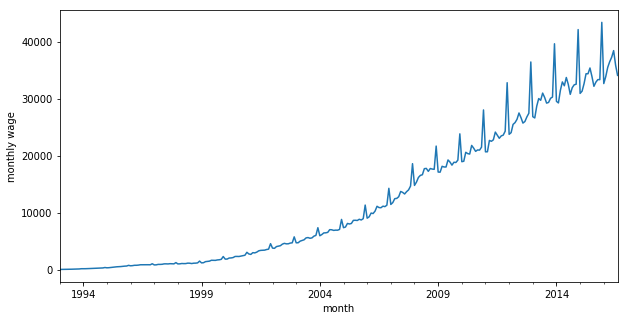

In [64]:
plt.figure(figsize(10, 5))
wage.monthly_wage.plot()
plt.ylabel('monthly wage')
plt.show()

Ряд явно нестационарный, присутствует тренд, сезонная составляющая. Дисперсия со временем увеличивается. Проведем STL-декомпозицию ряда, оценим его составляющие

Критерий Дики-Фуллера: p=0.991850


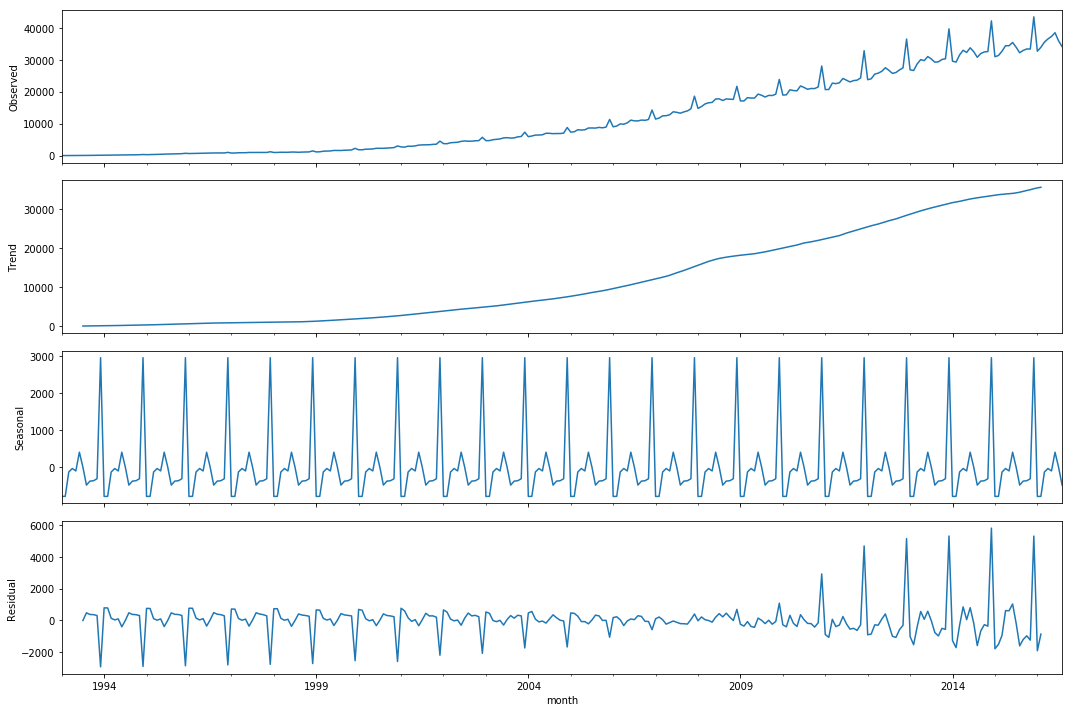

In [65]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.monthly_wage).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.monthly_wage)[1]);

### Стабилизируем дисперсию с помощью преобразования Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


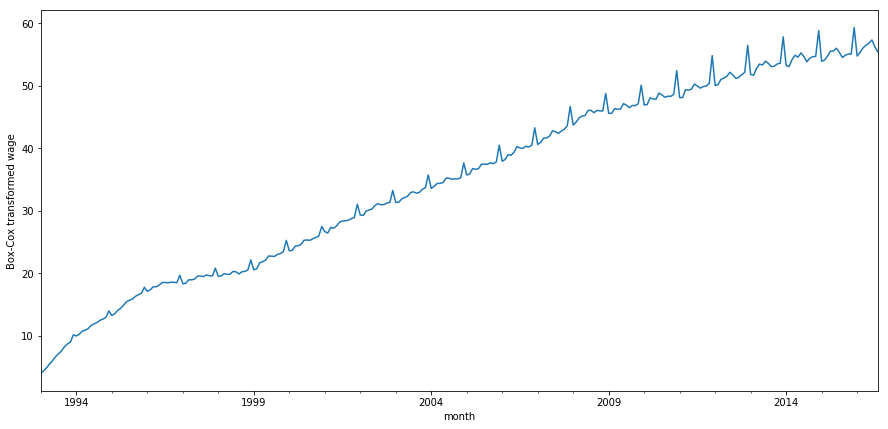

In [66]:
wage['wage_box'], lmbda = stats.boxcox(wage.monthly_wage)
plt.figure(figsize(15,7))
wage.wage_box.plot()
plt.ylabel(u'Box-Cox transformed wage')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box)[1])

#### Выбор порядка дифференцирования

В ряде явно прослеживается тренд. Попробуем применить сезонное дифференцирование

Критерий Дики-Фуллера: p=0.014697


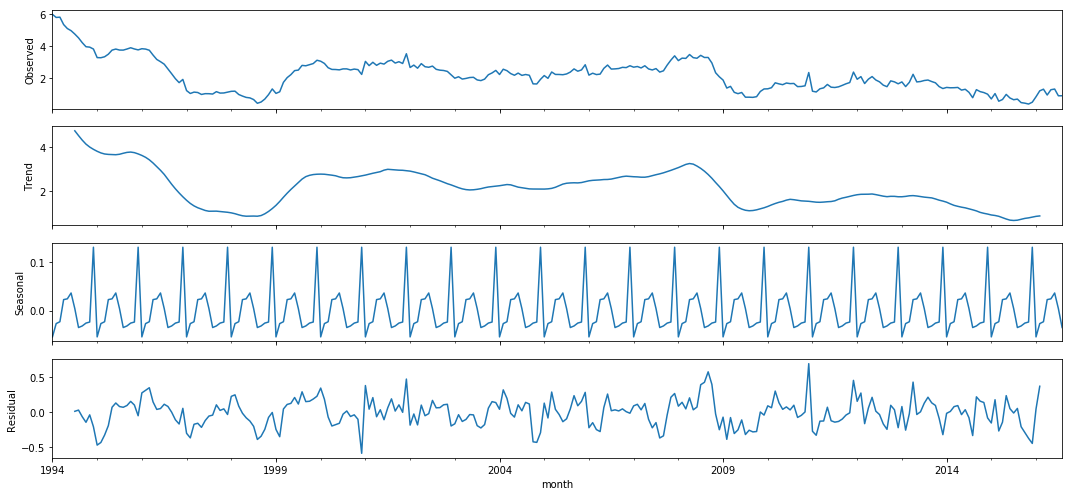

In [35]:
wage['wage_box_diff'] = wage.wage_box - wage.wage_box.shift(12) 
sm.tsa.seasonal_decompose(wage.wage_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает нулевую гипотезу, однако визуально в ряде еще присутствует тренд, а в остатках STL-декомпозиции наблюдается наличие структуры. Добавим обычное дифференцирование

Критерий Дики-Фуллера: p=0.000000


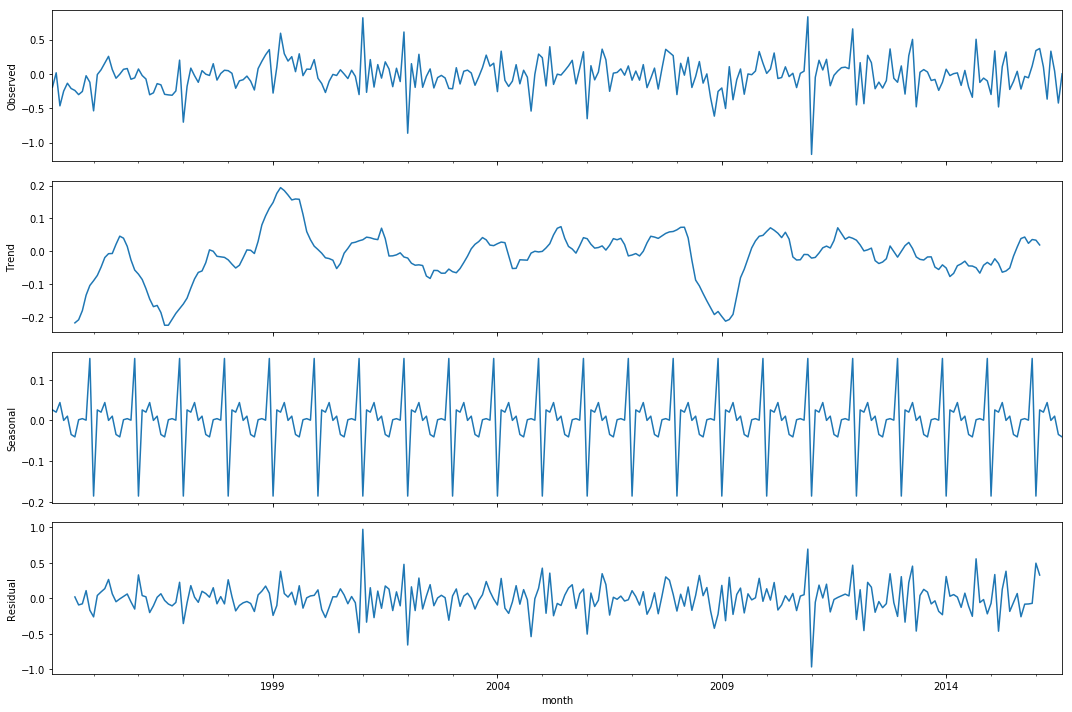

In [36]:
wage['wage_box_diff2'] = wage.wage_box_diff - wage.wage_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.wage_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box_diff2[13:])[1])

Теперь визуально ряд кажется лучше, а критерий Дики-Фуллера уверенно отвергает H0.

## Подбор модели

Посмотрим ACF и PACF

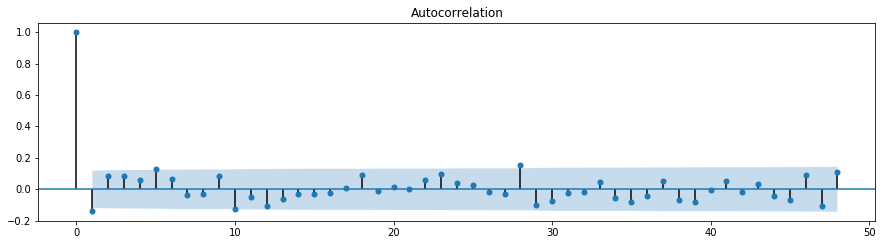

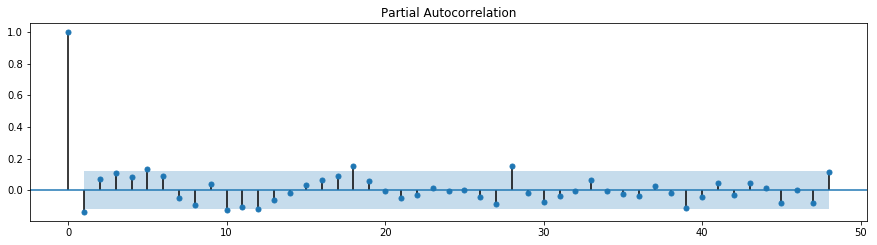

In [37]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения:
    Q = 0, q = 5
    P = 1, p = 10

In [52]:
ps = range(0, 11)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [53]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

132

In [54]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(wage.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 3, 0, 0))
('wrong parameters:', (2, 3, 1, 0))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 3, 0, 0))
('wrong parameters:', (3, 3, 1, 0))
('wrong parameters:', (3, 4, 0, 0))
('wrong parameters:', (3, 4, 1, 0))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 2, 1, 0))
('wrong parameters:', (4, 3, 0, 0))
('wrong parameters:', (4, 3, 1, 0))
('wrong parameters:', (4, 4, 0, 0))
('wrong parameters:', (4, 4, 1, 0))
('wrong parameters:', (5, 2, 0, 0))
('wrong parameters:', (5, 2, 1, 0))
('wrong parameters:', (5, 3, 0, 0))
('wrong parameters:', (5, 3, 1, 0))
('wrong parameters:', (5, 4, 0, 0))
('wrong parameters:', (5, 4, 1, 0))
('wrong parameters:', (6, 3,

In [55]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
44   (5, 5, 1, 0) -25.871490
52   (6, 5, 1, 0) -24.076972
43   (5, 5, 0, 0) -22.212560
51   (6, 5, 0, 0) -21.219761
83  (10, 3, 0, 0) -16.597163


In [56]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.936
Date:                            Tue, 24 Apr 2018   AIC                            -25.871
Time:                                    22:24:24   BIC                             17.916
Sample:                                01-01-1993   HQIC                            -8.316
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0172      4.702      0.004      0.997      -9.198       9.232
ar.L2          0.0103      3.173   

Остатки модели:

Критерий Стьюдента: p=0.187506
Критерий Дики-Фуллера: p=0.000000


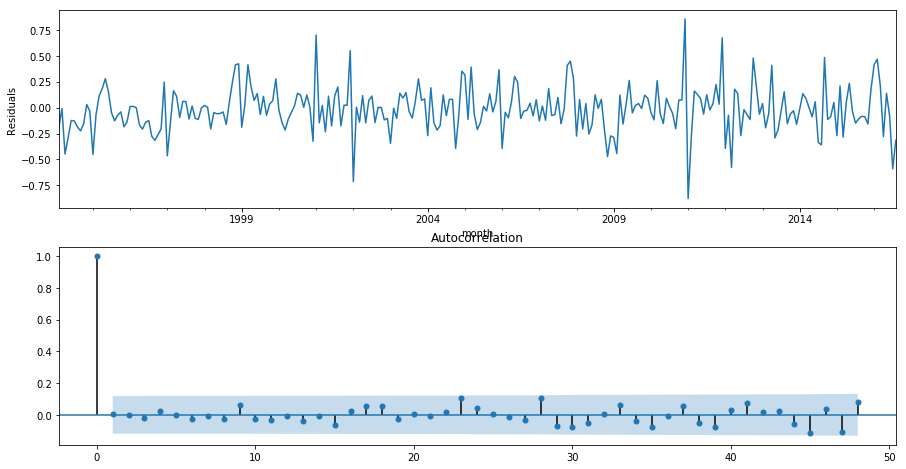

In [57]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

В соответствии с критерием Стьюдента остатки несмещены, в соответствии с критерием Дики-Фуллера - стационарны, а на основании критерия Льюнга-Бокса и коррелограммы можно считать, что они неавтокоррелированы.
Наложим прогноз на факт

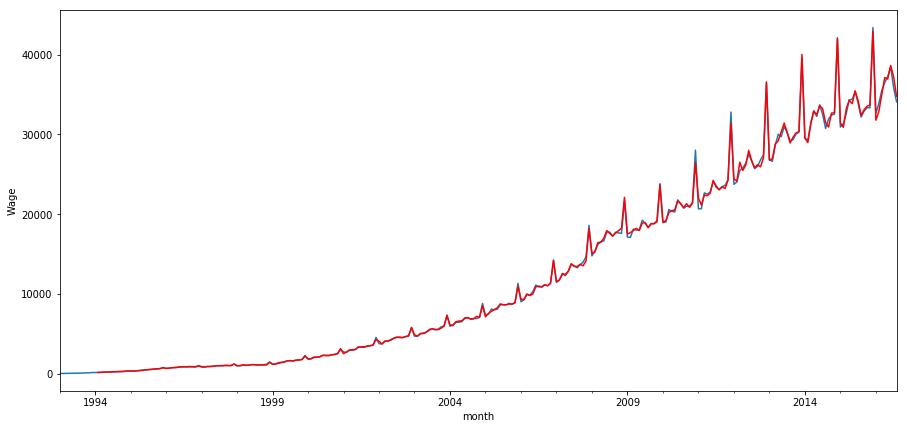

In [58]:
wage['predict'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wage.monthly_wage.plot()
wage.predict[13:].plot(color='r')
plt.ylabel('Wage')
pylab.show()

### Прогнозирование с помощью финальной модели

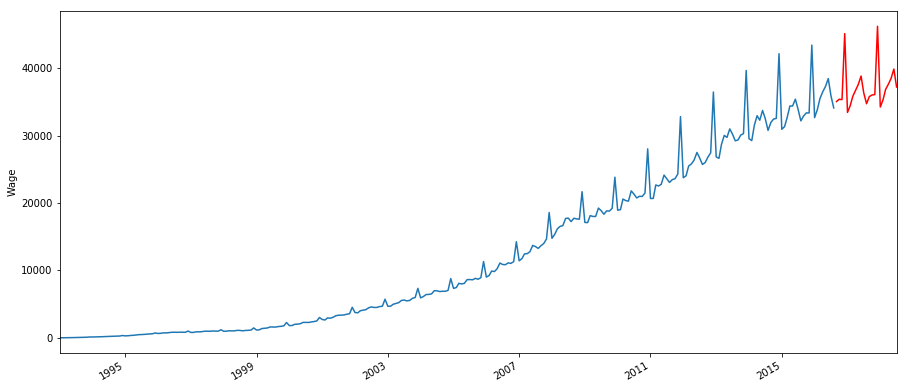

In [60]:
wage2 = wage[['monthly_wage']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0, 24)]
future = pd.DataFrame(index=date_list, columns= wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize(15,7))
wage2.monthly_wage.plot()
wage2.forecast.plot(color='r')
plt.ylabel('Wage')
pylab.show()

## Зарплата будет расти, это хорошо :)